In [19]:
len(scores)

41

---------- Apply decoder ----------
---------- Save decoder scores ----------
Saving scores to: ../data/bids/derivatives/decoding/sub-2/sub-2_task-imagine_run-1_desc-decode_from_stft_heard.npy
---------- Plot ----------


Text(0.5, 1.0, 'Sensor space decoding')

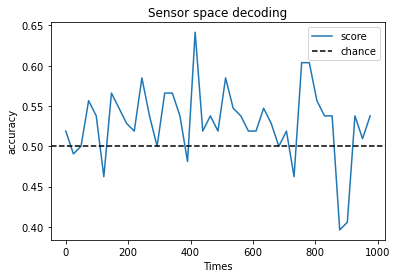

In [23]:

print("---------- Apply decoder ----------")
scores = estimator.score(Zxxs_imagined, y_imagined)
# scores = np.mean(scores, axis = 0) # average across cv splits

print("---------- Save decoder scores ----------")
print('Saving scores to: ' + scores_fpath)
np.save(scores_fpath, scores)

# Plot
print("---------- Plot ----------")
windows = list(range(len(scores)))
msec_per_window = 1000/41
x = [window*msec_per_window for window in windows]

fig, ax = plt.subplots()
ax.plot(x, scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

---------- Load data ----------
/project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz
Reading /project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
481 matching events found
No baseline correction applied
0 projection items activated
---------- Separate into heard and imagined epochs objects ----------
---------- Create event label dicts ----------
{'11': 10001, '12': 10002}
{'21': 10004, '22': 10005}
---------- Create target array ----------
y_heard: [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1

  0%|          | Fitting SlidingEstimator : 0/41 [00:00<?,       ?it/s]

---------- Apply decoder ----------
---------- Save decoder scores ----------
Saving scores to: ../data/bids/derivatives/decoding/sub-2/sub-2_task-imagine_run-1_desc-decode_from_stft_heard.npy
---------- Plot ----------


TypeError: object of type 'numpy.float64' has no len()

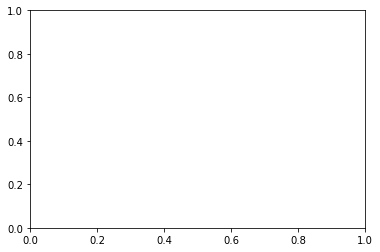

In [15]:
fpath = '/project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz'
sub = '2'
task = 'imagine'
run = '1'
cond = 'heard'
save_fpath = '../data/bids/derivatives/decoding/sub-2/sub-2_task-imagine_run-1_desc-stft_heard.npy'

print("---------- Load data ----------")
print(fpath)
epochs = mne.read_epochs(fpath)

print("---------- Separate into heard and imagined epochs objects ----------")
epochs_heard = epochs['11', '12']
events_heard = epochs_heard.events
epochs_imagined = epochsa['21', '22']
events_imagined = epochs_imagined.events

print("---------- Create event label dicts ----------")
print(epochs_heard.event_id)
label_dict_heard = {10001 : 0, 10002 : 1}
print(epochs_imagined.event_id)
label_dict_imagined = {10003 : 0, 10004 : 1}

print("---------- Create target array ----------")
labels_heard = pd.Series(events_heard[:, 2])
y_heard = labels_heard.replace(label_dict_heard)
le = preprocessing.LabelEncoder()
y_heard = le.fit_transform(y_heard)
print(f'y_heard: {y_heard}')

labels_imagined = pd.Series(events_imagined[:, 2])
y_imagined = labels_imagined.replace(label_dict_imagined)
le = preprocessing.LabelEncoder()
y_imagined = le.fit_transform(y_imagined)
print(f'y_heard: {y_imagined}')

print("---------- Load stft results ----------")
sink = DataSink(DERIV_ROOT, 'decoding')

# Load heard stfts
stft_heard = sink.get_path(
    subject = sub,
    task = task,
    run = run,
    desc = 'stft',
    suffix = 'heard',
    extension = 'npy',
)
print(f'Loading stft from {stft_heard}')
Zxxs_heard = np.load(stft_heard)

# Reshape for decoder
n_epochs_heard = np.shape(Zxxs_heard)[0]
if n_epochs_heard != np.shape(events_heard)[0]:
    sys.exit('Incorrect number of epochs')
n_freqs = 2
n_chans = 62
n_windows = 41
Zxxs_heard = Zxxs_heard.reshape((n_epochs_heard, n_freqs*n_chans, n_windows)) # n_epochs, n_freqs*n_chans, n_windows

# Load imagined stfts
stft_imagined = sink.get_path(
    subject = sub,
    task = task,
    run = run,
    desc = 'stft',
    suffix = 'imagined',
    extension = 'npy',
)
print(f'Loading stft from {stft_imagined}')
Zxxs_imagined = np.load(stft_imagined)

# Reshape for decoder
n_epochs_imagined = np.shape(Zxxs_imagined)[0]
if n_epochs_imagined != np.shape(events_imagined)[0]:
    sys.exit('Incorrect number of epochs')
n_freqs = 2
n_chans = 62
n_windows = 41
Zxxs_imagined = Zxxs_imagined.reshape((n_epochs_imagined, n_freqs*n_chans, n_windows)) # n_epochs, n_freqs*n_chans, n_windows

print("---------- Fit decoder ----------")
n_stimuli = 2
metric = 'accuracy'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver = 'liblinear')
)

print("Creating sliding estimators")
time_decod = SlidingEstimator(clf)

print("Fit estimators")
estimator = time_decod.fit(Zxxs_heard, y_heard)

print("---------- Apply decoder ----------")
scores = estimator.score(Zxxs_imagined, y_imagined)
# scores = np.mean(scores, axis = 0) # average across cv splits

print("---------- Save decoder scores ----------")
print('Saving scores to: ' + scores_fpath)
np.save(scores_fpath, scores)

# Plot
print("---------- Plot ----------")
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

In [13]:
# Test compute stft

from util.io.stft import *

fpath = '/project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz'
sub = '2'
task = 'imagine'
run = '1'
cond = 'heard'
save_fpath = '../data/bids/derivatives/decoding/sub-2/sub-2_task-imagine_run-1_desc-stft_heard.npy'

FS = 5000
CONDITION_FREQS = [190, 280]

# Read data
epochs = mne.read_epochs(fpath)
if cond == 'heard':
    epochs = epochs['11', '12']
elif cond == 'imagined':
    epochs = epochs['21', '22']
print(epochs)
epochs = epochs.get_data()
print(np.shape(epochs))

# # Get metadata
n_freqs = len(CONDITION_FREQS)
n_epochs = np.shape(epochs)[0]
print(n_epochs)
n_chans = np.shape(epochs)[1]

# Compute stft across all channels
Zxxs = np.empty([n_epochs, n_chans, n_freqs, 41]) # n_epochs, n_chans, n_freqs, n_windows
for chan in range(n_chans):
    x = pd.DataFrame(epochs[:, chan, :])
    f, t, Zxx = get_stft_for_one_channel(x, FS, n_epochs, CONDITION_FREQS)
    Zxxs[:, chan, :, :] = Zxx
print(np.shape(Zxxs))
# Save powers and events
# print(np.shape(Zxxs))
# print('Saving scores to: ' + save_fpath)
# np.save(save_fpath, Zxxs)

Reading /project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
481 matching events found
No baseline correction applied
0 projection items activated
<EpochsFIF |  369 events (all good), -0.5 - 0.5 sec, baseline -0.5 – 0 sec, ~873.0 MB, data loaded,
 '11': 164
 '12': 205>
(369, 62, 5001)
369
(369, 62, 2, 41)


In [11]:
np.shape(Zxxs)

(481, 62, 2, 41)

In [10]:
stft_fpath
# np.shape(Zxxs)[0]

'../data/bids/derivatives/decoding/sub-2/sub-2_task-imagine_run-1_desc-stft_heard.npy'

In [14]:
# Test decode from stft

import mne
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore

from util.io.bids import DataSink

fpath = '/project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz'
sub = '2'
task = 'imagine'
run = '1'
cond = 'heard'
scores_fpath = '../data/bids/derivatives/decoding/sub-2/sub-2_task-imagine_run-1_desc-decode_from_stft_heard.npy'

BIDS_ROOT = '../data/bids'
DERIV_ROOT = '../data/bids/derivatives'
FIGS_ROOT = '../figs'

print("---------- Load data ----------")
print(fpath)
epochs = mne.read_epochs(fpath)

print("---------- Separate heard epochs object ----------")
if cond == 'heard':
    epochs = epochs['11', '12']
    label_dict = {10001: 0, 10002: 1}
elif cond == 'imagined':
    epochs = epochs['21', '22']
    label_dict = {10003 : 0, 10004 : 1}
events = epochs.events

print("---------- Create target array ----------")
labels = pd.Series(events[:, 2])
y = labels.replace(label_dict)
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

print("---------- Load power computed from stft ----------")
DERIV_ROOT = '../data/bids/derivatives'
sink = DataSink(DERIV_ROOT, 'decoding')
stft_fpath = sink.get_path(
    subject = sub,
    task = task,
    run = run,
    desc = 'stft',
    suffix = cond,
    extension = 'npy',
)
print(f'Loading stft from {stft_fpath}')
Zxxs = np.load(stft_fpath)

# Reshape for decoder
n_epochs = np.shape(Zxxs)[0]
print(n_epochs)
print(np.shape(events)[0])
if n_epochs != np.shape(events)[0]:
    sys.exit('Incorrect number of epochs')
n_freqs = 2
n_chans = 62
n_windows = 41
Zxxs = Zxxs.reshape((n_epochs, n_freqs*n_chans, n_windows)) # n_epochs, n_freqs*n_chans, n_windows

---------- Load data ----------
/project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz
Reading /project2/hcn1/imagined_tone/analysis/../data/bids/derivatives/preprocessing/sub-2/sub-2_task-imagine_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
481 matching events found
No baseline correction applied
0 projection items activated
---------- Separate heard epochs object ----------
---------- Create target array ----------
---------- Load power computed from stft ----------
Loading stft from ../data/bids/derivatives/decoding/sub-2/sub-2_task-imagine_run-1_desc-stft_heard.npy
481
369


SystemExit: Incorrect number of epochs

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
np.shape(Zxxs)

(604, 62, 2, 41)

In [10]:
np.shape(Zxxs)

(756, 62, 2, 41)

In [11]:
epochs

Number of events,152
Events,21: 7622: 76
Time range,-0.500 – 0.500 sec
Baseline,-0.500 – 0.000 sec


In [4]:
epochs

Number of events,604
Events,11: 30012: 304
Time range,-0.500 – 0.500 sec
Baseline,-0.500 – 0.000 sec


In [1]:
import gc
import sys
import mne
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from typing import Tuple, Iterator
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore

In [2]:
BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'
STIM_FREQS = np.array([50, 100, 150, 200, 250])
np.random.seed(0)

In [3]:
print("---------- Load data ----------")
fpath = '/project2/hcn1/imagined_tone/data/bids/derivatives/preprocessing/sub-17/sub-17_task-imagine_run-1_desc-clean_epo.fif.gz'
epochs = mne.read_epochs(fpath)

---------- Load data ----------
Reading /project2/hcn1/imagined_tone/data/bids/derivatives/preprocessing/sub-17/sub-17_task-imagine_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
573 matching events found
No baseline correction applied
0 projection items activated


In [11]:
print("---------- Separate into heard and imagined epochs objects ----------")
epochs_heard = epochs['11', '12']
events_heard = epochs_heard.events
epochs_imagined = epochs['21', '22']
events_imagined = epochs_imagined.events

---------- Separate into heard and imagined epochs objects ----------


In [12]:
# Check event id tags and create label dict for decoder
print("---------- Create event label dicts ----------")
print(epochs_heard.event_id)
label_dict_heard = {10001 : 0, 10002 : 1}
print(epochs_imagined.event_id)
label_dict_imagined = {10003 : 0, 10004 : 1}

---------- Create event label dicts ----------
{'11': 10001, '12': 10002}
{'21': 10003, '22': 10004}


In [9]:
print("---------- Compute power ----------")
n_cycles = STIM_FREQS / 7 # different number of cycle per frequency
                           # higher constant, fewer windows, maybe?
    
# For epochs heard
power_heard = tfr_morlet(epochs_heard,
                   freqs = STIM_FREQS,
                   n_cycles = n_cycles,
                   use_fft = True,
                   return_itc = False,
                   decim = 3,
                   n_jobs = 1,
                   average = False)
power_heard = np.log10(power_heard)

# Get some information
n_epochs = np.shape(power_heard)[0]
n_channels = np.shape(power_heard)[1]
n_freqs = np.shape(power_heard)[2]
n_windows = np.shape(power_heard)[3]
print("n_windows: " + str(n_windows))

# Reshape for classifier
X_heard = power_heard.reshape((n_epochs, n_freqs * n_channels, n_windows)) # Set order to preserve epoch order
print(np.shape(X_heard))

# Repeat for epochs_imagined
power_imagined = tfr_morlet(epochs_imagined,
                   freqs = STIM_FREQS,
                   n_cycles = n_cycles,
                   use_fft = True,
                   return_itc = False,
                   decim = 3,
                   n_jobs = 1,
                   average = False)
power_imagined = np.log10(power_imagined)

# Get some information
n_epochs = np.shape(power_imagined)[0]
n_channels = np.shape(power_imagined)[1]
n_freqs = np.shape(power_imagined)[2]
n_windows = np.shape(power_imagined)[3]
print("n_windows: " + str(n_windows))

# Reshape for classifier
X_imagined = power_imagined.reshape((n_epochs, n_freqs * n_channels, n_windows)) # Set order to preserve epoch order
print(np.shape(X_imagined))

---------- Compute power ----------
Not setting metadata
n_windows: 1667
(456, 310, 1667)
Not setting metadata
n_windows: 1667
(117, 310, 1667)


In [17]:
print("---------- Create target array ----------")
labels_heard = pd.Series(events_heard[:, 2])
y_heard = labels_heard.replace(label_dict_heard)
le = preprocessing.LabelEncoder()
y_heard = le.fit_transform(y_heard)
print(f'y_heard: {y_heard}')

labels_imagined = pd.Series(events_imagined[:, 2])
y_imagined = labels_imagined.replace(label_dict_imagined)
le = preprocessing.LabelEncoder()
y_imagined = le.fit_transform(y_imagined)
print(f'y_heard: {y_imagined}')

---------- Create target array ----------
y_heard: [1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 1 1 1 1]
y_heard: [1 0 1 0 1 0 0

In [18]:
print("---------- Decode ----------")
n_stimuli = 2
metric = 'accuracy'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver = 'liblinear')
)

print("Creating sliding estimators")
time_decod = SlidingEstimator(clf)

print("Fit estimators")
estimator = time_decod.fit(X_heard, y_heard)

---------- Decode ----------
Creating sliding estimators
Fit estimators


  0%|          | Fitting SlidingEstimator : 0/1667 [00:00<?,       ?it/s]

In [21]:
print("---------- apply decoder ----------")
scores = estimator.score(X_imagined, y_imagined)

---------- apply decoder ----------


In [22]:
np.shape(scores)

(1667,)

In [34]:
windows = list(range(len(scores)))
msec_per_window = 1000/1667
x = [window*msec_per_window for window in windows]

999.4001199760047

In [ ]:
print("---------- Save decoder scores ----------")
print('Saving scores to: ' + scores_fpath)
np.save(scores_fpath, scores)

---------- Plot ----------


NameError: name 'sub' is not defined

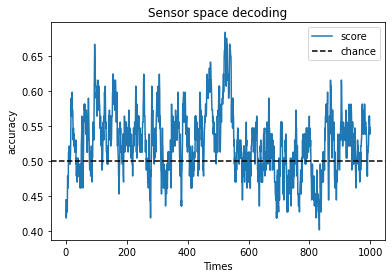

In [35]:
# Plot
print("---------- Plot ----------")
fig, ax = plt.subplots()
ax.plot(x, scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

# Save plot
fig_fpath = FIGS_ROOT + '/subj-' + sub + '_' + 'task-pitch_' + 'run-' + run + '_log_reg_no_crop' + '.png'
print('Saving figure to: ' + fig_fpath)
plt.savefig(fig_fpath)